In [ ]:
import numpy as np
import pandas as pd
import math
import xgboost as xgb
import matplotlib.pyplot as plt 
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import collections

## Splitting data into a training and validation set

In [ ]:
train = pd.read_csv('train.csv').drop(columns=['Unnamed: 0'])
test = pd.read_csv('test_nolabels.csv').drop(columns=['S.No'])
X = train.drop(columns='LABELS')
y = train.loc[:,['LABELS']]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=1, stratify=y)

## Standarization of the training and test points

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test = scaler.transform(test)

## Instantiation of the model

The model required the use of a GPU on colab, remove the parameter 'tree_method' if not using one. 

In [ ]:
model = xgb.XGBClassifier()
param_grid = {'objective':['binary:logistic'],
              'scale_pos_weight':[0.59],
             'eval_metric':['logloss'],
             'use_label_encoder':[False],
             'n_jobs':[-1],
              'max_depth':[11,12,13],
             'random_state':[1],
             'n_estimators':[800],
             'tree_method':['gpu_hist']}

In [ ]:
%%time
sample_weight = compute_sample_weight('balanced', np.ravel(y_train))
cv = StratifiedKFold(n_splits=50,shuffle=True)
search = GridSearchCV(model,param_grid,scoring='balanced_accuracy',cv=cv,refit=False,error_score='raise')
fit = search.fit(X_train_norm,np.ravel(y_train),sample_weight=sample_weight)

CPU times: user 40min 55s, sys: 13.4 s, total: 41min 8s
Wall time: 40min 57s


## Plotting the learning curves with respect to the evaluation metric

In [ ]:
%%time
evaluation_set = [(X_train_norm,np.ravel(y_train)),(X_val_norm,np.ravel(y_val))]
best_params = fit.best_params_
model.set_params(**best_params)

CPU times: user 124 µs, sys: 1 µs, total: 125 µs
Wall time: 128 µs


In [ ]:
# # Refit model
model = model.fit(X_train_norm,np.ravel(y_train),eval_metric=['auc'],eval_set=evaluation_set,verbose=False,early_stopping_rounds=10,sample_weight=sample_weight)
eval_results = model.evals_result()
# # Epochs
epochs = np.arange(len(eval_results['validation_1']['auc']))

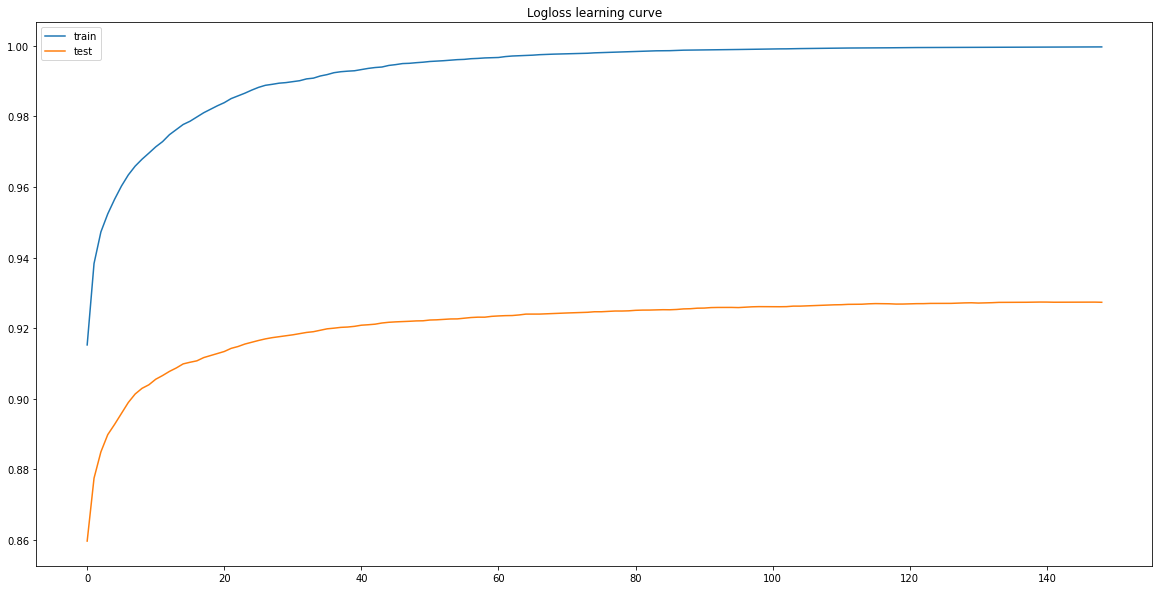

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(epochs, eval_results['validation_0']['auc'],label='train')
plt.plot(epochs, eval_results['validation_1']['auc'],label='test')
plt.title('Logloss learning curve')
plt.legend()
plt.show()

## Computing the accuracy of the model on the validation set

In [ ]:
val_preds = model.predict(X_val_norm)
accuracy = accuracy_score(y_val,val_preds)
print('Accuracy: {}%'.format(np.around(accuracy*100, 2)))

Accuracy: 84.69%


In [ ]:
print(f1_score(y_val, val_preds, average="binary"))

0.8811565179297829


## Data visualization

In [ ]:
print(classification_report(y_val,val_preds))

              precision    recall  f1-score   support

         0.0       0.74      0.83      0.78      4157
         1.0       0.91      0.85      0.88      8243

    accuracy                           0.85     12400
   macro avg       0.83      0.84      0.83     12400
weighted avg       0.85      0.85      0.85     12400



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


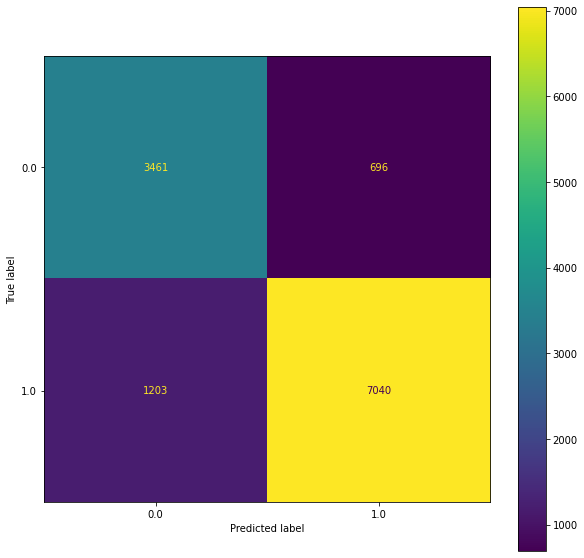

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(model,X_val_norm,y_val, ax=ax)
plt.show()

## Predicting our test set labels

In [ ]:
test_labels = model.predict(X_test).astype(int)

In [ ]:
df_submission = pd.DataFrame({'LABELS':test_labels})
df_submission.reset_index(inplace=True)
df_submission.rename(columns={'index':'S.No'},inplace=True)

In [ ]:
df_submission.LABELS.value_counts()

1    644
0    556
Name: LABELS, dtype: int64

In [ ]:
df_submission.LABELS.value_counts()
df_submission.to_csv('predictions_weighted_XGBoost.csv',index=False)